In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image

# Define the CNN model
class BrainMRINet(nn.Module):
    def __init__(self):
        super(BrainMRINet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 4)  # 4 classes
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)  # Added softmax activation

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        x = self.softmax(x)  # Apply softmax activation
        return x

# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root='../data/brain_mri', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = BrainMRINet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create lists to store metrics for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 20
patience = 4
best_accuracy = 0
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_losses.append(running_loss/len(train_loader))
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss/len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss:.4f}, Validation Accuracy: {100 * correct / total:.2f}%')
    
    # Early stopping
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    if epoch > 0:
        if val_accuracy <= best_accuracy:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                break
        else:
            patience_counter = 0
            best_accuracy = val_accuracy
    else:
        best_accuracy = val_accuracy
        patience_counter = 0

print(f'Best accuracy: {best_accuracy:.2f} at epoch {epoch+1}')

Using device: cuda
Epoch [1/20], Train Loss: 0.7338, Val Loss: 0.4233, Validation Accuracy: 85.27%
Epoch [2/20], Train Loss: 0.3791, Val Loss: 0.2875, Validation Accuracy: 88.33%
Epoch [3/20], Train Loss: 0.2314, Val Loss: 0.2150, Validation Accuracy: 91.89%
Epoch [4/20], Train Loss: 0.1521, Val Loss: 0.1691, Validation Accuracy: 93.31%
Epoch [5/20], Train Loss: 0.0860, Val Loss: 0.1693, Validation Accuracy: 93.88%
Epoch [6/20], Train Loss: 0.0540, Val Loss: 0.1533, Validation Accuracy: 95.16%
Epoch [7/20], Train Loss: 0.0483, Val Loss: 0.1853, Validation Accuracy: 94.09%
Epoch [8/20], Train Loss: 0.0427, Val Loss: 0.1725, Validation Accuracy: 95.23%
Epoch [9/20], Train Loss: 0.0428, Val Loss: 0.1582, Validation Accuracy: 95.52%
Epoch [10/20], Train Loss: 0.0273, Val Loss: 0.1541, Validation Accuracy: 96.44%
Epoch [11/20], Train Loss: 0.0210, Val Loss: 0.1828, Validation Accuracy: 94.95%
Epoch [12/20], Train Loss: 0.0293, Val Loss: 0.1691, Validation Accuracy: 95.59%
Epoch [13/20], Tra

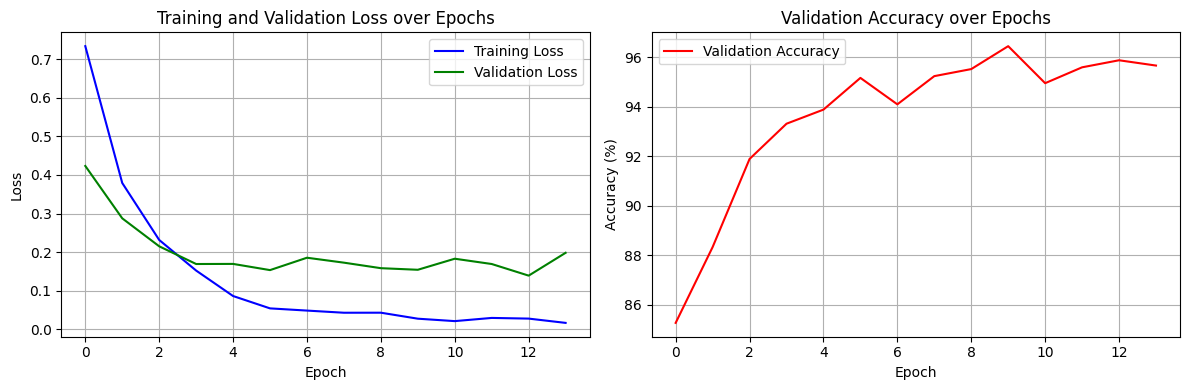

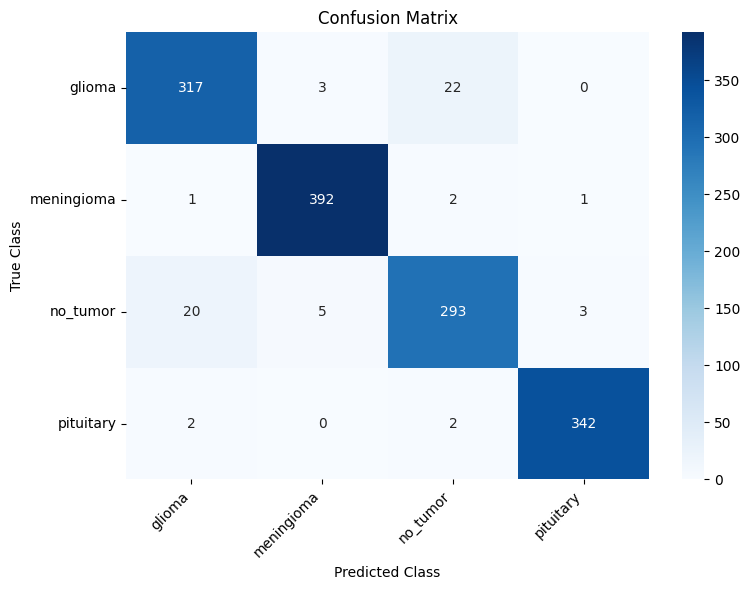

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Plot training loss and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'g-', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot validation accuracy 
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot confusion matrix for validation set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45, ha='right')
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)
plt.tight_layout()
plt.show()